
# Evaluating models


A very simple model linking the binarised self reported health with the deprivation index, controlled by age, for the UK. We emphasised understanding the model and developed intuition of what the model learns, but a modelling task is not complete without evaluation. Evaluation examines how well the model has learned the data and is able generalise it to unseen data.



In this section we will build on the modelling steps and perform model evaluation.  In this example we are focusing on logistic regression.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn import metrics
from matplotlib import pyplot
from scipy import stats

plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
sns.set_style("white")

<ipython-input-2-42b40561f429>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Data processing





In [3]:

df = pd.read_csv('eqls_2011.csv')
df_map = pd.read_csv('eqls_api_map.csv', encoding='latin1')

In [4]:
# we are only interested in the UK for this example.
df = df.query('Y11_Country == 27') # Romania code is 23

#Rename variables

var_map = {"Y11_Q42": "SRH",
           'Y11_Deprindex': 'DeprIndex',
           "Y11_Accommproblems": 'AccomProblems',
           "Y11_HHsize": "HouseholdSize",
           "Y11_Q32": "Children",
           "Y11_ISCEDsimple":"ISCED",
           "Y11_SocExIndex":"SocialExclusionIndex",
           "Y11_MWIndex": "MentalWellbeingIndex",
           "Y11_Agecategory":"AgeCategory",
           "Y11_HH2a":"Gender",
           "Y11_Q31":"MaritalStatus",
           "Y11_Country":"Country"
}

df.rename(columns=var_map, inplace=True)
df_set = df[var_map.values()]

<ipython-input-4-0ac3be0dad13>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=var_map, inplace=True)


We drop rows with missing data.

In [5]:
df_model = df_set.dropna()

In [6]:
# Missing data imputation


In [7]:
df_model.head()

,SRH,DeprIndex,AccomProblems,HouseholdSize,Children,ISCED,SocialExclusionIndex,MentalWellbeingIndex,AgeCategory,Gender,MaritalStatus,Country
36,2.0,2.0,2.0,3,0.0,2.0,2.50,72.0,1,1,4.0,27
38,3.0,5.0,2.0,4,2.0,6.0,4.25,36.0,3,1,1.0,27
39,2.0,0.0,0.0,4,0.0,6.0,1.75,56.0,1,2,4.0,27
40,3.0,0.0,1.0,4,3.0,6.0,2.00,92.0,2,1,1.0,27
41,2.0,0.0,0.0,3,0.0,6.0,2.00,72.0,1,1,4.0,27


Self-rated health SRH is the rating that individuals give to their health status. It is a global measure both of mental state and of physical condition

The exact wordings and response options of self-rated health questions vary. In the question that is most widely used in the US, responses are set out on a scale from excellent through very good, good and fair to poor, while the options recommended by WHO (1996) and the EURO-REVES 2 group (Robine et al., 2003) are very good, good, fair, bad and very bad; there is also a version that uses the options very good, fairly good, average, fairly bad, and bad (Heikkinen et al., 1983, Jylhä et al., 1998).

In [8]:
df_model['SRH'].unique()
#We have 5 values, as I described, we need only 2 values


array([2., 3., 1., 4., 5.])

Finally, we dichotomise the `SRH` variable.

In [9]:
# dichotomise SRH Self-Rated Health
df_model['SRH_binary'] = df_model.SRH.apply(lambda x: 1 if float(x) <= 3 else 0)

<ipython-input-9-6bb219c2696a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['SRH_binary'] = df_model.SRH.apply(lambda x: 1 if float(x) <= 3 else 0)


In [10]:
df_model.head()

#Now we have only 2 variables, 1 for values >3 and 0 for values <=3 (means that 1 is associated with a good health status)

,SRH,DeprIndex,AccomProblems,HouseholdSize,Children,ISCED,SocialExclusionIndex,MentalWellbeingIndex,AgeCategory,Gender,MaritalStatus,Country,SRH_binary
36,2.0,2.0,2.0,3,0.0,2.0,2.50,72.0,1,1,4.0,27,1
38,3.0,5.0,2.0,4,2.0,6.0,4.25,36.0,3,1,1.0,27,1
39,2.0,0.0,0.0,4,0.0,6.0,1.75,56.0,1,2,4.0,27,1
40,3.0,0.0,1.0,4,3.0,6.0,2.00,92.0,2,1,1.0,27,1
41,2.0,0.0,0.0,3,0.0,6.0,2.00,72.0,1,1,4.0,27,1


## Model 1: Age and Deprivation index.

Let's start evaluating the performance of a simple model where we model `SRH` as a function of `Age` and `DeprIndex`.



Deprivation index: No. of items a household can't afford.

In [11]:
# test train split using scikit learn, defining random state for reproducibility
trainX_model1, testX_model1, trainy_model1, testy_model1 = train_test_split(df_model[['AgeCategory','DeprIndex']], df_model.SRH_binary.values, test_size=0.3, random_state=2)

In [12]:
model1 = LogisticRegression(penalty='none')
result_model1 = model1.fit(trainX_model1, trainy_model1)
# Intercept and Coeficients for 'AgeCategory' and 'DeprIndex'
result_model1.intercept_, result_model1.coef_

#The larger the intercept, the higher the logarithm of the reference odds, indicating a higher initial probability of belonging to the positive class.
#The smaller a coefficient, the smaller the impact of changes in that feature on the logarithm of the odds. If a coefficient is negative,
#an increase in the value of that feature will lead to a decrease in the logarithm of the odds of belonging to the positive class.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


(array([4.50665758]), array([[-0.47165863, -0.43115774]]))

## Evaluation through predicting new data
  
Now we evaluate our model using our test dataset.

Logistic regression works by first obtaining the prediction of the model as a probability, then binarising the predicted probability using a threshold value. Scores above the threshold value will be classified as positive, those below as negative. For now the threshold value of the probability is $P(x)>0.5$.

In [16]:
# performing predictions on the test dataset
yhat = result_model1.predict_proba(testX_model1)[:,1]
pred_y_model1 = list(map(round, yhat))

# comparing first 10 original and predicted values of y
print('Actual values', list(testy_model1)[:10])
print('Predictions :', pred_y_model1[:10])

Actual values [1, 1, 1, 1, 0, 1, 1, 0, 1, 1]
Predictions : [1, 1, 1, 1, 1, 0, 1, 1, 1, 1]


Accuracy: 0.8803986710963455
Precision: 0.8902027027027027
Recall: 0.9868913857677902


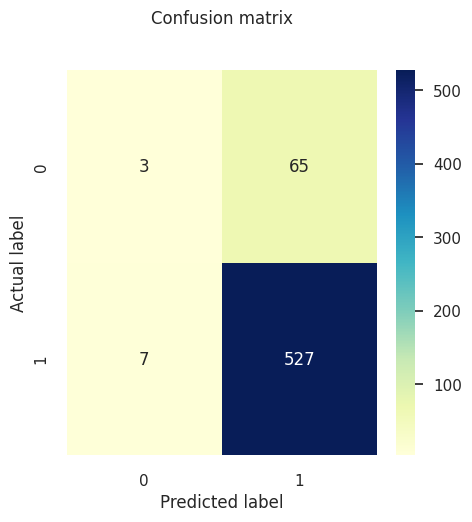

In [17]:
# confusion matrix using sklearn
cnf_matrix = metrics.confusion_matrix(testy_model1,pred_y_model1)

def plt_cnf_mat(cnf_matrix, ax, class_names=[0,1]):
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.set_title('Confusion matrix', y=1.1)
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')


fig, ax = plt.subplots(1,1, figsize = (5,5))
plt_cnf_mat(cnf_matrix, ax)


print("Accuracy:",metrics.accuracy_score(testy_model1, pred_y_model1))
print("Precision:",metrics.precision_score(testy_model1, pred_y_model1))
print("Recall:",metrics.recall_score(testy_model1, pred_y_model1))

In [18]:
#You can see here that very few true negative values get predicted and the overwhelming majority of responses are true positives.
#Furthermore, the accuracy, precision, and recall score > 85%, this is happening due to our dataset being highly imbalanced and that the minority class are labeled as negative (0).
testy_model1_minority = abs(testy_model1 - 1)
pred_y_model1_minority = abs(np.array(pred_y_model1) -1)

print("Specificity:",metrics.recall_score(testy_model1_minority, pred_y_model1_minority))

Specificity: 0.04411764705882353


The classification matrix  might not be the best tool to evaluate the model in this scenario. Particularly because it shows a snapshot of the results being mapped from a predicted probability using a threshold of $p(x)> 0.5$.


### Investigating threshold values



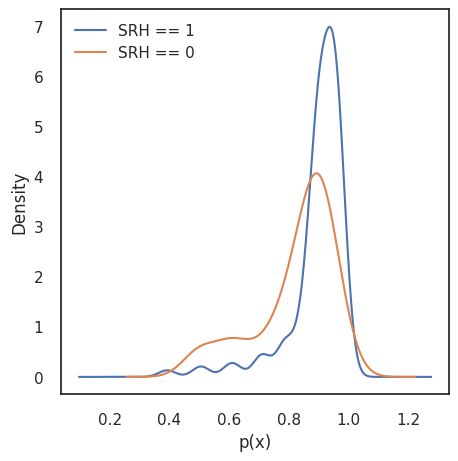

In [19]:
# link the prediction to the label values
#go back to our probability and investigate the predicted values given by the model for our two labels:

df_labels = pd.DataFrame({'prediction': yhat,
     'label': testy_model1})

fig, ax = plt.subplots(1,1, figsize = (5,5))
df_labels[df_labels['label']==1]['prediction'].plot.kde(label='SRH == 1')
df_labels[df_labels['label']==0]['prediction'].plot.kde(label='SRH == 0')
pyplot.xlabel('p(x)')
pyplot.legend()



In [20]:
df_labels.head()

,prediction,label
0,0.895516,1
1,0.783478,1
2,0.932139,1
3,0.932139,1
4,0.895516,0


Ideally, in this density plot we would observe separate probability scores between two classes, with the score of the cases where `SRH==0` on the low probability values and the score of cases with `SRH==1` on the the high values. However, in the current case both distributions are skewed to the high probability values. The reason for this is because our dataset is highly imbalanced and only consists of 10 percent of cases where `SRH ==0`. Thus the predicted probabilities get pulled towards higher values because of the majority of the data being positive cases.

In [21]:
print ('Mean value for SRH ==1,', round(df_labels[df_labels['label']==1]['prediction'].mean(),3))
print ('Mean value for SRH ==0,', round(df_labels[df_labels['label']==0]['prediction'].mean(),3))
print ('Percentage of cases with SRH ==0,', round(df_labels[df_labels['label']==0]['prediction'].count()/df_labels.shape[0],3))

Mean value for SRH ==1, 0.895
Mean value for SRH ==0, 0.823
Percentage of cases with SRH ==0, 0.113


Despite all this, in the density figures above we can observe a separation in the predicted scores, and the performance of the model could be improved by selecting a better threshold value for $p(x)$ to classify each case. This should be done by balancing the rate of False Positives and False Negatives. To assess this trade-off we can use other tools available, such as **ROC curves**.



A receiver operating characteristic curve, or ROC curve, is a figure that illustrates the performance of a binary classifier as its discrimination threshold is varied.

Let's examine how the ROC curve looks for our model, and how it compares to a dummy classifier with no skill in classifying our data.

In [22]:
# function from https://stackoverflow.com/questions/22518230/creating-a-threshold-coded-roc-plot-in-python
def plot_roc(labels, predictions, positive_label, thresholds_every=10, title='', c='darkorange'):
    # fp: false positive rates. tp: true positive rates
    fp, tp, thresholds = roc_curve(labels, predictions, pos_label=positive_label)
    roc_auc = roc_auc_score(labels, predictions)

    plt.plot(fp, tp, label=title+' ROC curve (area = %0.2f)' % roc_auc, linewidth=2, color=c)
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=2)
    plt.xlabel('False positives rate')
    plt.ylabel('True positives rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.title('ROC curve (numbers are threshold values)')
    plt.legend(loc="lower right")
    plt.grid(True)

    # plot some thresholds
    thresholdsLength = len(thresholds)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_three_decimals = str(thresholds[i])[:4]
        plt.text(fp[i] - 0.05, tp[i] + 0.015, threshold_value_with_max_three_decimals, fontdict={'size': 10},color=c)

In [23]:
lr_probs_model1 = result_model1.predict_proba(testX_model1)
# keep probabilities for the positive outcome only
lr_probs_model1 = lr_probs_model1[:, 1]

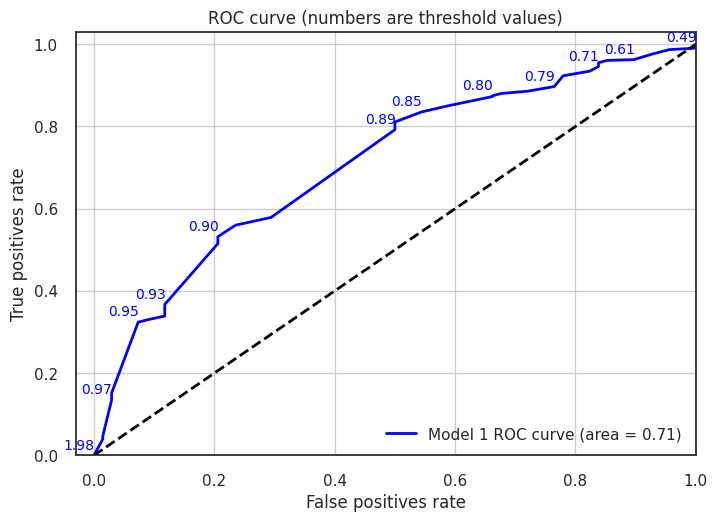

In [24]:
plot_roc(testy_model1, lr_probs_model1, positive_label=1, thresholds_every=3, title="Model 1",c='blue')

The AUC values printed above reflects the area under the ROC curve and provides a measure of how discriminant the model is between the two classes.  [In general, an AUC of 0.5 means no discrimination, 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding]

A value of 0.5 for AUC indicates that the ROC curve will fall on the diagonal (45-degree line) and hence suggests that the diagnostic test has no discriminatory ability.

Here we confirm again that our model has learned something and performs better than an "unskilled" dummy classifier. Now, we can use the ROC values to obtain an optimal threshold value. We'll use Youden index method.



In [25]:
# function inspired by https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def find_optimal_threshold(target, predicted):
    """ Find the optimal probability threshold for a classification model.
    Parameters
    ----------
    target : Matrix with label data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------
    a float, with optimal cutoff value

    """
    fpr, tpr, thresholds = roc_curve(target, predicted)
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

threshold = find_optimal_threshold(df_labels['label'], df_labels['prediction'])
print (round(threshold,4))

0.9064


This is quite far from the 0.5 value we originally had! Let's see how our classification matrix does now using this new threshold.

In this case we have decided that the optimal threshold value is the one that, which  maximises the True Positive rate and minimizes the False Positive rate. However, the definition of **optimal** really depends of the research question or the task we are to solve. An alternative would be to give more importance in accurately classifying our `SRH=0` class and try to maximise the True Negative Rate.


Accuracy: 0.553156146179402

Precision: 0.9522184300341296
Recall: 0.5224719101123596

Specificity: 0.7941176470588235


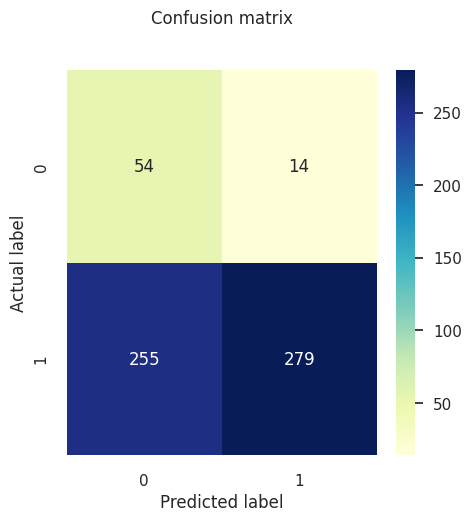

In [26]:
# performing predictions on the test dataset
# yhat = result_model1.predict(testX_model1)
yhat = result_model1.predict_proba(testX_model1)[:,1]
pred_y_model1 =  [1 if x > threshold else 0 for x in yhat]


# confusion matrix using sklearn
cnf_matrix = metrics.confusion_matrix(testy_model1,pred_y_model1)

fig, ax = plt.subplots(1,1, figsize = (5,5))
plt_cnf_mat(cnf_matrix, ax)


print("Accuracy:",metrics.accuracy_score(testy_model1, pred_y_model1))

print ()
print("Precision:",metrics.precision_score(testy_model1, pred_y_model1))
print("Recall:",metrics.recall_score(testy_model1, pred_y_model1))

print ()
testy_model1_minority = abs(testy_model1 - 1)
pred_y_model1_minority = abs(np.array(pred_y_model1) -1)

print("Specificity:",metrics.recall_score(testy_model1_minority, pred_y_model1_minority))

The specificity for our minority label (`SRH==0`) has improved using the new threshold value, at a large expense of the classification performance of the majority label (`SRH==1`).